Emily Picinich

Mapping the Customer Journey: Predicting Purchase Conversion through Behavioral Analytics

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

In [3]:
# Load data into a DataFrame
df = pd.read_csv('customer_journey.csv')

# EDA

In [5]:
# Preview the data
df.head()

,SessionID,UserID,Timestamp,PageType,DeviceType,Country,ReferralSource,TimeOnPage_seconds,ItemsInCart,Purchased
0,session_0,user_2223,2025-01-20 22:53:34,home,Desktop,India,Social Media,55,0,0
1,session_1,user_2192,2025-02-26 12:57:10,home,Tablet,Germany,Email,99,0,0
2,session_1,user_2192,2025-02-26 12:59:11,product_page,Tablet,Germany,Email,121,0,0
3,session_2,user_1708,2025-06-24 15:40:46,home,Mobile,India,Google,160,0,0
4,session_3,user_2976,2025-06-11 07:21:02,home,Tablet,UK,Google,113,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12719 entries, 0 to 12718
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SessionID           12719 non-null  object
 1   UserID              12719 non-null  object
 2   Timestamp           12719 non-null  object
 3   PageType            12719 non-null  object
 4   DeviceType          12719 non-null  object
 5   Country             12719 non-null  object
 6   ReferralSource      12719 non-null  object
 7   TimeOnPage_seconds  12719 non-null  int64 
 8   ItemsInCart         12719 non-null  int64 
 9   Purchased           12719 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 993.8+ KB


In [7]:
# Check for missing data
df.isna().sum()

SessionID             0
UserID                0
Timestamp             0
PageType              0
DeviceType            0
Country               0
ReferralSource        0
TimeOnPage_seconds    0
ItemsInCart           0
Purchased             0
dtype: int64

In [8]:
# Check for duplicate rows in the DataFrame
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows in df: {num_duplicates}")

Number of duplicate rows in df: 0


In [9]:
# Split columns by data type
num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
cat_cols = [c for c in df.columns if not np.issubdtype(df[c].dtype, np.number)]
print('\n# numeric cols:', len(num_cols), '| # categorical cols:', len(cat_cols))


# numeric cols: 3 | # categorical cols: 7


In [10]:
# Show summary statistics
if num_cols:
    print('\nnumeric describe:\n', df[num_cols].describe().T)

if cat_cols:
    nunique = df[cat_cols].nunique().sort_values(ascending=False)
    print('\ncategorical unique counts:\n', nunique)


numeric describe:
                       count       mean        std   min   25%   50%    75%  \
TimeOnPage_seconds  12719.0  97.427707  48.120729  15.0  56.0  98.0  139.0   
ItemsInCart         12719.0   1.138533   1.689954   0.0   0.0   0.0    2.0   
Purchased           12719.0   0.397044   0.489304   0.0   0.0   0.0    1.0   

                      max  
TimeOnPage_seconds  180.0  
ItemsInCart           5.0  
Purchased             1.0  

categorical unique counts:
 Timestamp         12713
SessionID          5000
UserID             1872
Country               7
PageType              5
ReferralSource        4
DeviceType            3
dtype: int64


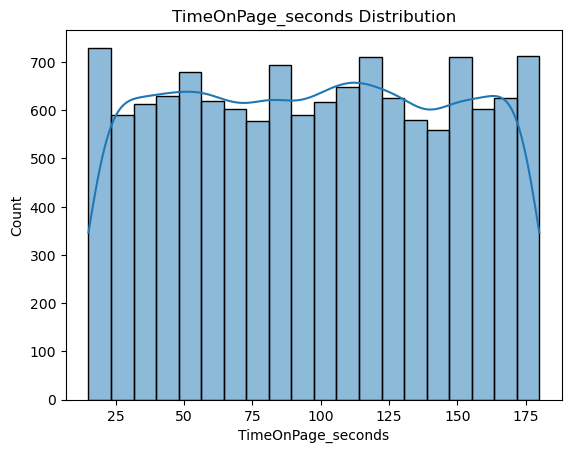

In [11]:
# Plot the time on page distribution
sns.histplot(df['TimeOnPage_seconds'], 
             bins=20, 
             kde=True
            )
plt.title('TimeOnPage_seconds Distribution')
plt.show()

The data appear to be fairly uniform, meaning that customers are spending a wide range of times on the page, with no strong clustering around a specific duration. The bars are relatively even in height, suggesting that time on page is spread evenly between short and long visits. There is no clear peak or skew, which indicates that customers are equally likely to spend a short, moderate, or long amount of time browsing.

The smooth blue line (the kernel density estimate) further supports this observation, showing small fluctuations but no pronounced central tendency. This pattern suggests that user engagement time varies widely, and that the page does not have a typical or dominant viewing duration. In practical terms, it may imply that visitors interact with the page in different ways, some scanning quickly and others exploring more deeply, without a single behavior pattern dominating the user experience.

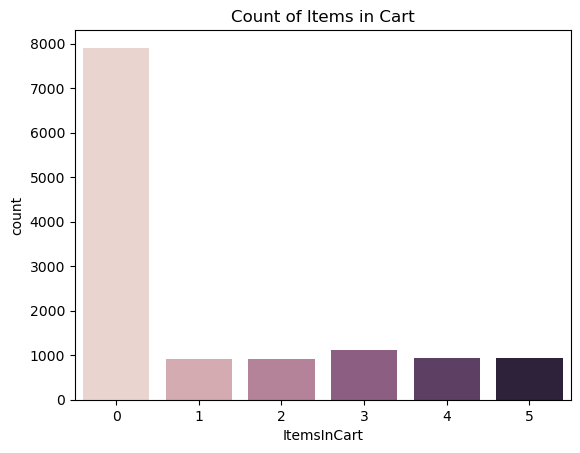

In [13]:
# Plot count of page types
sns.countplot(data=df,
              x='ItemsInCart',
              hue='ItemsInCart',
              legend=False
             )
plt.title('Count of Items in Cart')
plt.show()

The vast majority of customers, around 8,000, had zero items in their cart, meaning they visited the site but did not add anything. The remaining values from 1 to 5 are much smaller and relatively consistent in size, suggesting that only a small subset of users progressed to the cart stage, and those who did tended to add a few items rather than many.

This distribution indicates that most customers are browsing without purchasing intent or failing to convert. It reflects a strong drop-off between product viewing and engagement with the cart. From a business perspective, this could signal a need to improve product appeal, pricing, website usability, or checkout flow to encourage more users to add items to their carts.

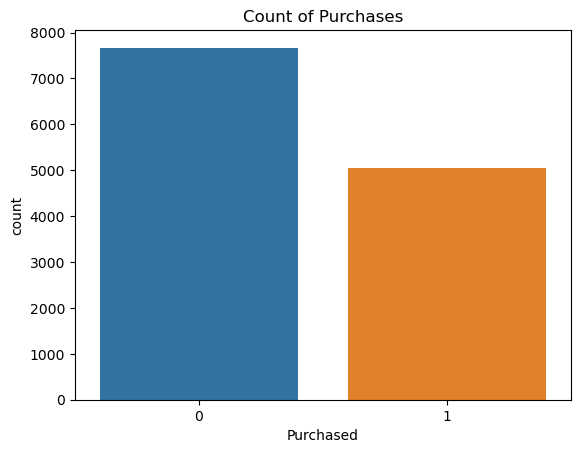

In [15]:
# Plot count of purchases
sns.countplot(data=df,
              x='Purchased',
              hue='Purchased',
              legend=False
             )
plt.title('Count of Purchases')
plt.show()

Each bar shows how many customers either completed a purchase (1) or did not (0). The plot reveals that more customers did not make a purchase compared to those who did, but the difference is not extreme. The non-purchasing group is somewhat larger, with around 7,700 observations, while approximately 5,000 customers completed a purchase. This indicates a moderate class imbalance, where non-purchasers make up a slightly higher proportion of the dataset.

From a business standpoint, this distribution suggests that while a majority of users browse without completing a transaction, a substantial portion still converts, meaning there is meaningful variation to analyze. The presence of both groups in significant numbers makes this dataset well-suited for building predictive models, as it provides enough information to understand which factors most strongly influence purchasing behavior.

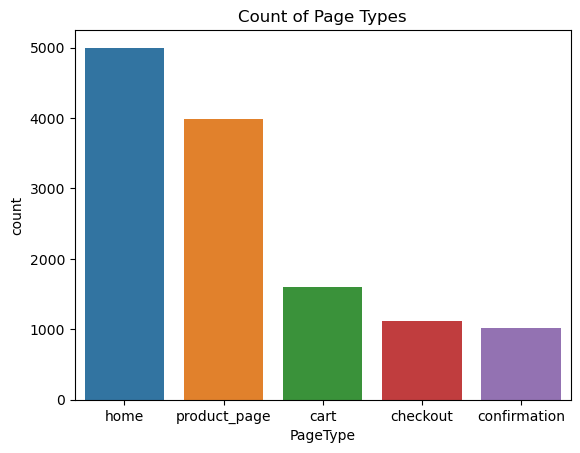

In [17]:
# Plot count of page types
sns.countplot(data=df,
              x='PageType',
              hue='PageType',
              legend=False
             )
plt.title('Count of Page Types')
plt.show()

The home page has the highest count, with about 5,000 visits, indicating that most users start or spend time on the homepage. The product page is the next most visited, with roughly 4,000 views, suggesting that a large portion of users proceed to explore individual products. However, there is a noticeable drop in activity beyond that point. The cart, checkout, and confirmation pages receive progressively fewer visits, around 1,500, 1,100, and 1,000 respectively, highlighting a clear funnel effect.

This pattern reflects a typical e-commerce behavior flow: high engagement at the beginning of the customer journey, followed by significant drop-offs as users move closer to completing a purchase. From a business perspective, this suggests that while the site effectively attracts visitors and product interest, a smaller proportion continue through the purchasing stages. Improving user experience, reducing friction during checkout, or offering incentives at later stages could help increase the number of users reaching the confirmation page.

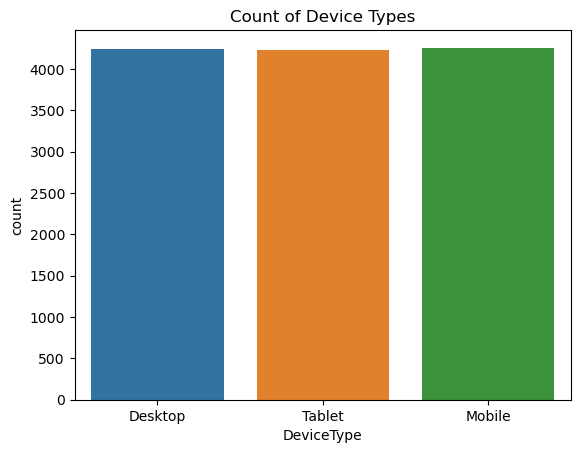

In [19]:
# Plot count of device types
sns.countplot(data=df,
              x='DeviceType',
              hue='DeviceType',
              legend=False
             )
plt.title('Count of Device Types')
plt.show()

The three categories, Desktop, Tablet, and Mobile, have almost equal counts, each with around 4,200 users. This balanced distribution suggests that the website attracts a diverse mix of users across all device types, without a dominant platform. It indicates that customers engage with the site through multiple channels, which is important for e-commerce businesses aiming for accessibility and consistency across devices.

From an analytical standpoint, this even usage pattern means that purchase behavior or engagement should be evaluated across all device types, as no single platform overwhelmingly drives traffic. It also emphasizes the importance of maintaining an optimized, responsive design and consistent user experience across desktop, tablet, and mobile interfaces to ensure conversions remain steady across all devices.

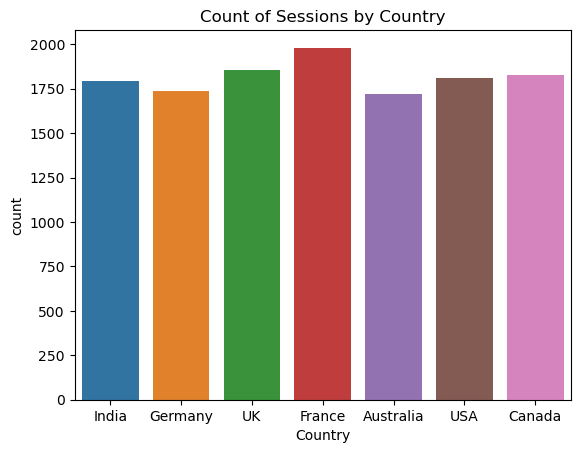

In [21]:
# Plot count of sessions by countries
sns.countplot(data=df,
              x='Country',
              hue='Country',
              legend=False
             )
plt.title('Count of Sessions by Country')
plt.show()

The data indicates that sessions are fairly evenly spread across all seven countries, with only minor variations between them. France recorded the highest number of sessions, close to 2,000, followed closely by the UK, Canada, India, and the USA. Germany and Australia show slightly lower counts, but the differences are relatively small. This even distribution suggests that the website has a broad international reach, attracting consistent engagement across multiple major markets.

From a business perspective, this pattern implies that no single country dominates site traffic, meaning the company’s customer base is globally diversified. Maintaining localized marketing strategies, region-specific content, and optimized delivery options could help strengthen engagement and conversion rates across all these regions.

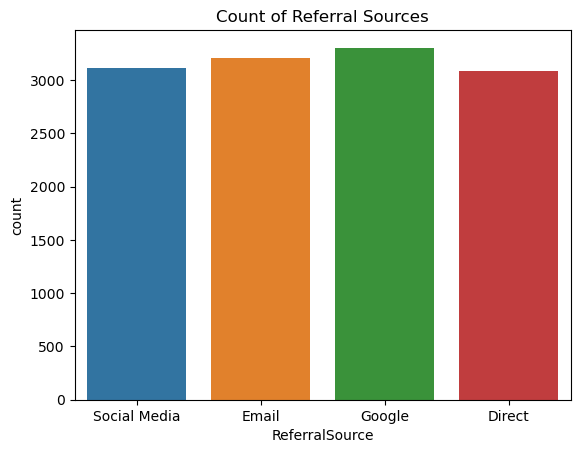

In [23]:
# Plot count of referral sources
sns.countplot(data=df,
              x='ReferralSource',
              hue='ReferralSource',
              legend=False
             )
plt.title('Count of Referral Sources')
plt.show()

The four main channels, Social Media, Email, Google, and Direct, all contribute almost equally to overall traffic, with each generating around 3,000 sessions. The slight variation among them indicates a balanced marketing ecosystem where no single source overwhelmingly dominates. Google leads marginally, suggesting that organic search or paid search campaigns are slightly more effective in driving visitors. Email and Social Media follow closely, showing that marketing communications and social engagement are both strong channels. Direct traffic, users who typed the URL or used bookmarks, also accounts for a substantial portion, reflecting brand familiarity and returning visitors.

From a business perspective, this even distribution is a positive sign. It implies that the company’s marketing strategy successfully diversifies user acquisition across multiple channels, reducing reliance on any single source. Maintaining this balance while optimizing each channel for higher conversion rates could strengthen overall site performance and customer acquisition efficiency.


Correlation and p-values with target (numeric):
               Feature  Correlation       p_value
1         ItemsInCart     0.154557  7.813618e-69
0  TimeOnPage_seconds    -0.007306  4.099791e-01

With significance levels:

              Feature  Correlation       p_value   Significance
1         ItemsInCart     0.154557  7.813618e-69  *** (p<0.001)
0  TimeOnPage_seconds    -0.007306  4.099791e-01             ns


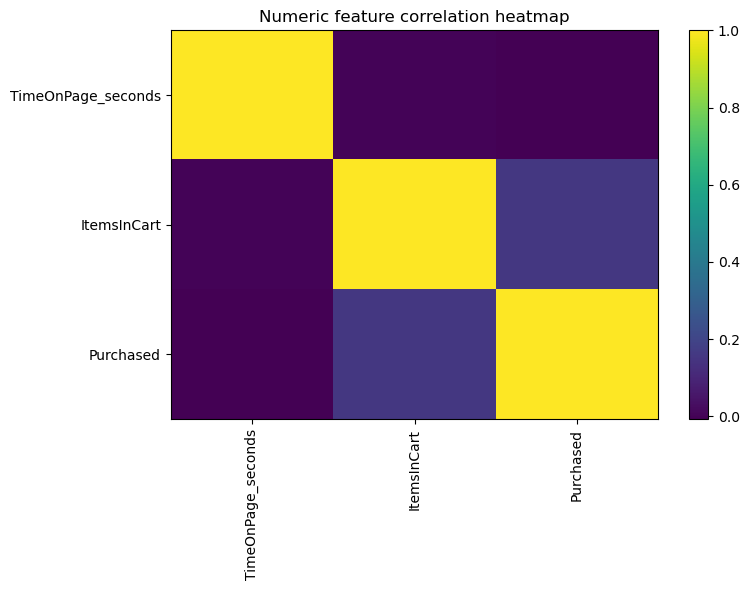

In [71]:
from scipy.stats import pearsonr

# define target column
target = 'Purchased'

if num_cols:
    # calculate correlation and p-value for each numeric column vs target
    corr_results = []
    for col in num_cols:
        if col != target:
            r, p = pearsonr(df[col], df[target])
            corr_results.append({'Feature': col, 'Correlation': r, 'p_value': p})
    
    # convert to DataFrame and sort by absolute correlation
    corr_df = pd.DataFrame(corr_results).sort_values(by='Correlation', key=lambda x: x.abs(), ascending=False)
    print('\nCorrelation and p-values with target (numeric):\n', corr_df)

    # significance flag
    corr_df['Significance'] = corr_df['p_value'].apply(
        lambda p: '*** (p<0.001)' if p < 0.001 else
                  '** (p<0.01)' if p < 0.01 else
                  '* (p<0.05)' if p < 0.05 else 'ns'
    )

    print('\nWith significance levels:\n')
    print(corr_df[['Feature', 'Correlation', 'p_value', 'Significance']])

    # plot correlation heatmap
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title('Numeric feature correlation heatmap')
    plt.tight_layout()
    plt.show()

The analysis shows that ItemsInCart has a positive correlation of 0.155 with Purchased, and this relationship is highly statistically significant with a p-value below 0.001. Although the correlation strength is relatively modest, it is meaningful because it indicates that customers who add more items to their carts are more likely to complete a purchase. This aligns with typical e-commerce behavior, where cart activity is a key indicator of buying intent. Even a small positive correlation here provides valuable insight into customer engagement and conversion likelihood.

In contrast, TimeOnPage_seconds has a correlation very close to zero, at –0.007, with a p-value of approximately 0.41. This result shows that there is no statistically significant relationship between the amount of time a user spends on a page and their likelihood of making a purchase. It suggests that spending more time on the site does not necessarily indicate stronger purchase intent—visitors who linger might be browsing, comparing options, or uncertain about buying.

The accompanying heatmap visually supports these results. The yellow diagonal represents perfect correlations of 1.0, which occur when a variable is correlated with itself. The darker area between Purchased and TimeOnPage_seconds shows almost no relationship, while the slightly lighter shading between Purchased and ItemsInCart reflects the small but positive correlation. Overall, this analysis indicates that the number of items in a user’s cart is a significant behavioral signal for predicting purchase outcomes, while time spent on a page is not a reliable predictor of buying behavior.

In [58]:
from scipy.stats import chi2_contingency

# Function to compute both Cramér’s V and p-value
def cramers_v_with_pval(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    cramers_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return cramers_v, p

In [64]:
# Define categorical columns and target
target = 'Purchased'
cat_cols = ['DeviceType', 'Country', 'PageType', 'ReferralSource']

In [66]:
# Compute metrics for each categorical variable
results = []
for col in cat_cols:
    v, p = cramers_v_with_pval(df[col], df[target])
    results.append({'Feature': col, 'CramersV': v, 'p_value': p})

results_df = pd.DataFrame(results).sort_values('CramersV', ascending=False)
print(results_df)

          Feature  CramersV   p_value
2        PageType  0.576007  0.000000
1         Country  0.027118  0.017683
3  ReferralSource  0.023143  0.020232
0      DeviceType  0.000000  0.905531


This table shows the Cramér’s V correlation coefficients and p-values for the relationship between four categorical variables and the target variable Purchased. The results reveal how strongly and significantly each feature is associated with purchase behavior.

The most influential variable is PageType, with a Cramér’s V of 0.576 and a p-value of 0.000000, indicating a strong and highly significant relationship with whether a user made a purchase. This suggests that the type of page a customer visits, such as home, product, cart, or checkout, has a major impact on the likelihood of completing a purchase. Customers who reach deeper funnel pages (like checkout or confirmation) are much more likely to convert.

The variables Country (Cramér’s V = 0.027, p = 0.018) and ReferralSource (Cramér’s V = 0.023, p = 0.020) show weak but statistically significant relationships. Although these effects are small, they suggest that geographic location and how a user arrives at the site (such as via Google, email, or social media) may slightly influence purchase behavior, perhaps due to cultural preferences or marketing effectiveness in certain regions or channels.

Lastly, DeviceType shows no association with purchase outcomes (Cramér’s V = 0.000, p = 0.906). This indicates that whether a customer uses a desktop, tablet, or mobile device does not meaningfully affect their likelihood of purchasing.

Overall, the analysis shows that PageType is the only categorical variable with a substantial and meaningful relationship to purchase behavior, making it a key feature for predicting conversions. The other variables contribute minimally and may serve as secondary or context features in a predictive model.

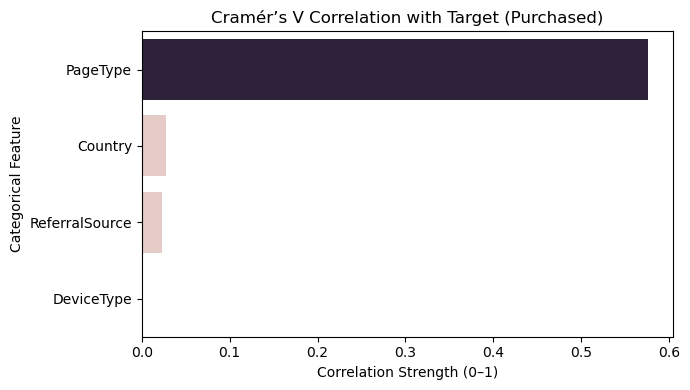

In [68]:
# Plot the correlation strengths
plt.figure(figsize=(7,4))
sns.barplot(x='CramersV', 
            y='Feature', 
            data=results_df, 
            hue='CramersV',
            legend=False
           )
plt.title('Cramér’s V Correlation with Target (Purchased)')
plt.xlabel('Correlation Strength (0–1)')
plt.ylabel('Categorical Feature')
plt.tight_layout()
plt.show()

In [87]:
# Check for outliers in numeric columns
def iqr_outlier_share(s):
    q1, q3 = np.nanpercentile(s, 25), np.nanpercentile(s, 75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    frac = np.mean((s < lo) | (s > hi))
    return frac

if num_cols:
    outlier_share = pd.Series({c: iqr_outlier_share(df[c].values) for c in num_cols}).sort_values(ascending=False)
    print('\noutlier share (IQR rule):\n', outlier_share.head(20))


outlier share (IQR rule):
 TimeOnPage_seconds    0.0
ItemsInCart           0.0
Purchased             0.0
dtype: float64


The outlier share for each variable is 0.0, meaning that no data points were identified as outliers under the IQR criterion. This indicates that the dataset is well-behaved numerically, with all values falling within reasonable ranges and no extreme deviations. It suggests that the data has consistent scaling and distribution patterns, which is beneficial for modeling since outliers can often skew results or bias machine learning algorithms. In short, the absence of outliers implies that the dataset is clean and reliable for further analysis and predictive modeling.

# Models

In [18]:
# Set target variable
TARGET_COL = 'Purchased'
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

In [20]:
# Convert target to numeric (1 = purchased, 0 = not)
if y.dtype == object:
    y = y.str.lower().map({"yes": 1, "no": 0, "true": 1, "false": 0})
y = pd.to_numeric(y, errors="coerce").fillna(0).astype(int)

In [22]:
# Create engagement score if related columns exist
cand_cols = [c for c in X.columns if any(k in c.lower() for k in ["view", "click", "time", "duration", "page", "cart"])]
if cand_cols:
    sub = X[cand_cols].apply(pd.to_numeric, errors="coerce")
    norm = (sub - sub.min()) / (sub.max() - sub.min() + 1e-9)
    X["engagement_score"] = norm.mean(axis=1)

In [24]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
# Preprocessing
num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
cat_cols = [c for c in X.columns if c not in num_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

In [28]:
# Models
models = {
    "Logistic Regression": Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))]),
    "Random Forest": Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample"))])
}

In [30]:
# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    results[name] = auc
    print(f"\n=== {name} ===")
    print(f"ROC-AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred, digits=4))


=== Logistic Regression ===
ROC-AUC: 0.959
              precision    recall  f1-score   support

           0     0.8514    0.9485    0.8973      1534
           1     0.9054    0.7485    0.8195      1010

    accuracy                         0.8691      2544
   macro avg     0.8784    0.8485    0.8584      2544
weighted avg     0.8728    0.8691    0.8664      2544


=== Random Forest ===
ROC-AUC: 0.858
              precision    recall  f1-score   support

           0     0.7734    0.9100    0.8362      1534
           1     0.8133    0.5950    0.6872      1010

    accuracy                         0.7850      2544
   macro avg     0.7933    0.7525    0.7617      2544
weighted avg     0.7892    0.7850    0.7771      2544



The results show that the Logistic Regression model performed exceptionally well overall. With a ROC-AUC of 0.959, it demonstrates excellent ability to distinguish between customers who made a purchase and those who did not, correctly differentiating the two classes nearly 96% of the time. Its accuracy of 0.869 indicates that about 87% of all records were correctly classified. The precision for customers who purchased is 0.905, meaning that when the model predicts a purchase, it is correct roughly 90.5% of the time. Its recall of 0.748 suggests that it successfully identified about three-quarters of the customers who actually purchased. This trade-off indicates that the model is somewhat conservative, favoring precision over recall; it is cautious about labeling someone as a likely purchaser, resulting in fewer false positives but some missed true purchasers. The F1-score of 0.82 confirms a strong balance between precision and recall, showing that the model performs reliably in predicting actual buyers. Overall, Logistic Regression delivers consistently high performance across all evaluation metrics and remains interpretable and stable, making it well suited for business decisions where avoiding wasted marketing efforts is important.

In comparison, the Random Forest model achieved a solid but lower level of performance. Its ROC-AUC of 0.858 is still good but clearly below Logistic Regression, indicating that it is less effective at distinguishing between purchasers and non-purchasers. The model’s accuracy of 0.785 shows that it correctly classified around 79% of the data. Although the precision for predicting purchasers is fairly high at 0.813, the recall drops to 0.595, revealing that the model misses a significant portion of actual purchasers. This imbalance is further reflected in its lower F1-score of 0.687. The results suggest that while Random Forest can model nonlinear relationships, it may be overfitting or less well-calibrated for this dataset. It is more cautious in identifying purchasers, resulting in lower recall and making it less effective in marketing scenarios where finding as many potential buyers as possible is valuable.

In [32]:
# Show best model
best_model = max(results, key=results.get)
print(f"\nBest model: {best_model} (ROC-AUC = {results[best_model]:.3f})")


Best model: Logistic Regression (ROC-AUC = 0.959)


When comparing the two models, Logistic Regression clearly outperforms Random Forest in nearly every metric, including AUC, accuracy, F1-score, and recall. It provides stronger predictive accuracy while maintaining a good balance between identifying actual purchasers and avoiding false alarms. From a business perspective, Logistic Regression is the preferred model for this dataset because it is both interpretable and efficient. It effectively captures the key patterns that drive purchasing behavior and provides actionable insights that can support more targeted and data-driven marketing strategies.

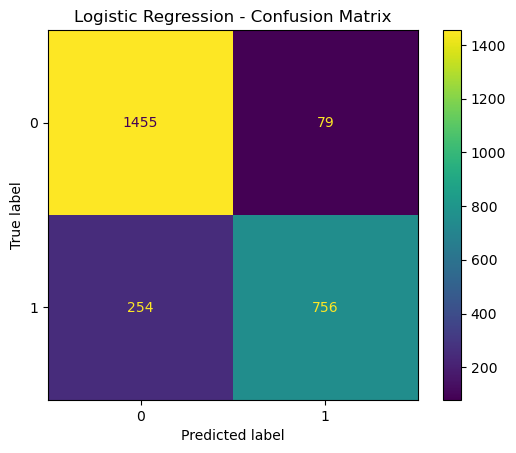

In [40]:
# Plot logistic regression confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, models[best_model].predict(X_test))).plot()
plt.title(f"{best_model} - Confusion Matrix")
plt.show()

This confusion matrix visualizes how well the Logistic Regression model classified customer purchases. The matrix shows four outcomes based on the comparison between predicted and actual values.

The top-left cell (1,455) represents the number of true negatives, meaning the model correctly predicted that these customers did not make a purchase. The top-right cell (79) shows the false positives, or cases where the model incorrectly predicted a purchase even though the customer did not buy anything. The bottom-left cell (254) represents the false negatives, meaning the model predicted no purchase when a customer actually did buy. Finally, the bottom-right cell (756) contains the true positives, the customers correctly identified as purchasers.

Overall, the model correctly classified the majority of both purchasers and non-purchasers. It performed particularly well at identifying non-purchasers, with very few false positives (only 79 out of more than 1,500 non-buyers). However, it missed a moderate number of actual purchasers (254), which explains the lower recall for the positive class. In practical terms, the model is highly reliable when it predicts that a customer will buy, but it is somewhat conservative and may fail to identify some potential buyers. This trade-off results in high precision but slightly lower recall, which is consistent with the earlier performance metrics and makes the model useful for marketing scenarios that prioritize accuracy in targeting likely buyers.

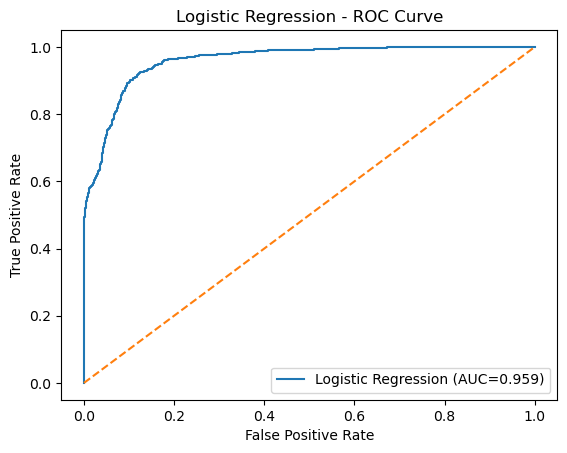

In [36]:
# Plot logistic regression ROC Curve
fpr, tpr, _ = roc_curve(y_test, models[best_model].predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"{best_model} (AUC={results[best_model]:.3f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{best_model} - ROC Curve")
plt.legend()
plt.show()

This ROC curve illustrates how well the Logistic Regression model distinguishes between customers who made a purchase and those who did not. The blue curve represents the model’s performance across different classification thresholds, while the orange dashed diagonal line represents random guessing. The further the blue curve is from this diagonal, the better the model’s ability to separate the two classes.

In this case, the curve rises sharply toward the top-left corner, showing that the model achieves a high true positive rate while maintaining a low false positive rate. The Area Under the Curve (AUC) value of 0.959 indicates excellent discriminatory power, meaning the model can correctly differentiate between purchasers and non-purchasers about 96% of the time.

Overall, this ROC curve confirms that the Logistic Regression model is highly effective and well-calibrated. It demonstrates strong sensitivity and specificity, maintaining a near-ideal balance between correctly identifying purchasers and avoiding false alarms. This level of performance suggests that the model can be confidently used for predicting purchasing behavior and targeting potential customers with a high degree of accuracy.